# 📊 EMC Spectrum Analysis Notebook

Questo notebook permette di fare esperimenti di analisi dati sugli spettri EMC per rapid prototyping.

## Obiettivi:
- 📈 **Import spettri**: Leggere dati JSON e CSV come nel codice attuale
- 🔍 **Peak extraction**: Rilevare picchi significativi nei segnali
- 📊 **Misure-mask**: Confrontare misure con limiti EMC
- 🚀 **Rapid prototyping**: Testare algoritmi di analisi velocemente

## Struttura:
1. Import delle librerie necessarie
2. Caricamento e parsing dei dati JSON
3. Visualizzazione e esplorazione dati
4. Peak detection e estrazione
5. Implementazione masking delle misure
6. Funzioni di analisi spettrale
7. Filtraggio interattivo dei dati
8. Export dei risultati

## 1. Import Required Libraries

Importiamo tutte le librerie necessarie per l'analisi spettrale EMC.

In [15]:
# Import librerie base
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Import librerie per signal processing
from scipy import signal
from scipy.signal import find_peaks, peak_widths, peak_prominences
from scipy.interpolate import interp1d

# Import librerie per analisi dati
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Import librerie per visualizzazioni interattive
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Import librerie per widgets interattivi
from ipywidgets import interact, widgets
from IPython.display import display, HTML

# Configurazione plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

print("✅ Librerie importate con successo!")
print("📦 Versioni:")
print(f"   - pandas: {pd.__version__}")
print(f"   - numpy: {np.__version__}")
# print(f"   - scipy: {signal.__version__}")
print(f"   - matplotlib: {plt.matplotlib.__version__}")
print(f"   - seaborn: {sns.__version__}")

✅ Librerie importate con successo!
📦 Versioni:
   - pandas: 2.3.1
   - numpy: 2.2.6
   - matplotlib: 3.10.3
   - seaborn: 0.13.2


## 2. Load and Parse JSON Spectrum Data

Carichiamo i dati JSON degli standard EMC e delle misure, come nel codice attuale della web app.

In [ ]:
def load_emc_standards(json_path='../public/emc-standards.json'):
    """
    Carica gli standard EMC dal file JSON (come nella web app)
    """
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
        
        standards = {}
        for std_id, std_data in data['standards'].items():
            standards[std_id] = {
                'name': std_data['name'],
                'description': std_data['description'],
                'limits': std_data['limits']
            }
        
        print(f"✅ Caricati {len(standards)} standard EMC:")
        for std_id, std_data in standards.items():
            limit_types = list(std_data['limits'].keys())
            print(f"   - {std_data['name']} ({', '.join(limit_types)})")
        
        return standards
    
    except FileNotFoundError:
        print(f"❌ File non trovato: {json_path}")
        return {}
    except json.JSONDecodeError as e:
        print(f"❌ Errore parsing JSON: {e}")
        return {}

def parse_measurement_data(file_path, delimiter=','):
    """
    Carica dati di misura da file CSV/TXT
    Supporta file nella cartella data/ o percorsi assoluti
    """
    # Se il percorso non è assoluto, prova nella cartella data/
    if not file_path.startswith('/') and not file_path.startswith('data/'):
        file_path = f'data/{file_path}'
    
    try:
        # Prova diversi delimitatori
        for delim in [delimiter, ';', '\t', ' ']:
            try:
                df = pd.read_csv(file_path, delimiter=delim)
                if len(df.columns) >= 2:
                    break
            except:
                continue
        
        # Standardizza i nomi delle colonne
        df.columns = ['frequency', 'amplitude'] + list(df.columns[2:])
        
        # Converte a numerico
        df['frequency'] = pd.to_numeric(df['frequency'], errors='coerce')
        df['amplitude'] = pd.to_numeric(df['amplitude'], errors='coerce')
        
        # Rimuove NaN
        df = df.dropna(subset=['frequency', 'amplitude'])
        
        print(f"✅ Caricati {len(df)} punti di misura da {file_path}")
        print(f"   - Freq range: {df['frequency'].min():.3f} - {df['frequency'].max():.3f} MHz")
        print(f"   - Ampl range: {df['amplitude'].min():.1f} - {df['amplitude'].max():.1f} dBμV")
        
        return df
    
    except Exception as e:
        print(f"❌ Errore caricamento {file_path}: {e}")
        return pd.DataFrame()

def generate_logarithmic_mask(limit_points, freq_range=None, num_points=1000):
    """
    Genera maschera logaritmica dai punti limite (come nella web app)
    """
    if not limit_points:
        return pd.DataFrame()
    
    # Filtra punti validi
    valid_points = [(f, a) for f, a in limit_points if f is not None and a is not None]
    
    if len(valid_points) < 2:
        return pd.DataFrame()
    
    # Ordina per frequenza
    valid_points.sort(key=lambda x: x[0])
    
    mask_data = []
    
    # Interpolazione logaritmica tra punti
    for i in range(len(valid_points) - 1):
        freq1, amp1 = valid_points[i]
        freq2, amp2 = valid_points[i + 1]
        
        # Genera punti logaritmici
        log_freq1 = np.log10(freq1)
        log_freq2 = np.log10(freq2)
        
        # Più punti nelle zone di transizione
        steps = max(50, int(abs(log_freq2 - log_freq1) * 100))
        
        for j in range(steps):
            ratio = j / steps
            log_freq = log_freq1 + (log_freq2 - log_freq1) * ratio
            freq = 10 ** log_freq
            amp = amp1 + (amp2 - amp1) * ratio  # Interpolazione lineare in dB
            
            mask_data.append({'frequency': freq, 'amplitude': amp})
    
    # Aggiungi ultimo punto
    mask_data.append({'frequency': valid_points[-1][0], 'amplitude': valid_points[-1][1]})
    
    mask_df = pd.DataFrame(mask_data)
    
    # Applica range di frequenza se specificato
    if freq_range:
        mask_df = mask_df[
            (mask_df['frequency'] >= freq_range[0]) & 
            (mask_df['frequency'] <= freq_range[1])
        ]
    
    return mask_df

# Test di caricamento
print("🔄 Caricamento dati di esempio...")
emc_standards = load_emc_standards()

# Crea dati di misura di esempio se non ci sono file
if not emc_standards:
    print("📝 Creando dati di esempio...")
    
    # Genera spettro di esempio
    frequencies = np.logspace(np.log10(0.15), np.log10(1000), 500)  # 0.15 MHz - 1 GHz
    
    # Segnale base + rumore + alcuni picchi
    base_signal = 30 + 10 * np.log10(frequencies)  # Trend crescente
    noise = np.random.normal(0, 3, len(frequencies))
    
    # Aggiungi alcuni picchi
    peaks_freq = [1.2, 5.5, 25.8, 155.0, 433.0]
    peaks_amp = [15, 20, 12, 18, 25]
    
    amplitudes = base_signal + noise
    for pf, pa in zip(peaks_freq, peaks_amp):
        idx = np.argmin(np.abs(frequencies - pf))
        amplitudes[idx] += pa
    
    # Crea DataFrame
    sample_data = pd.DataFrame({
        'frequency': frequencies,
        'amplitude': amplitudes
    })
    
    print(f"✅ Generati {len(sample_data)} punti di misura di esempio")
    print(f"   - Freq range: {frequencies.min():.3f} - {frequencies.max():.3f} MHz")
    print(f"   - Ampl range: {amplitudes.min():.1f} - {amplitudes.max():.1f} dBμV")

🔄 Caricamento dati di esempio...
✅ Caricati 6 standard EMC:
   - ECE R-10 2012 AC line (avg, qp)
   - ECE R-10 2012 DC line (avg, qp)
   - EN 55032 Class A (avg, qp, pk)
   - EN 55032 Class B (avg, qp, pk)
   - CISPR 32 Class A (avg, qp, pk)
   - CISPR 32 Class B (avg, qp, pk)


## 3. Data Visualization Functions

🎯 Funzioni di visualizzazione pronte!
📊 Prova plot di esempio...


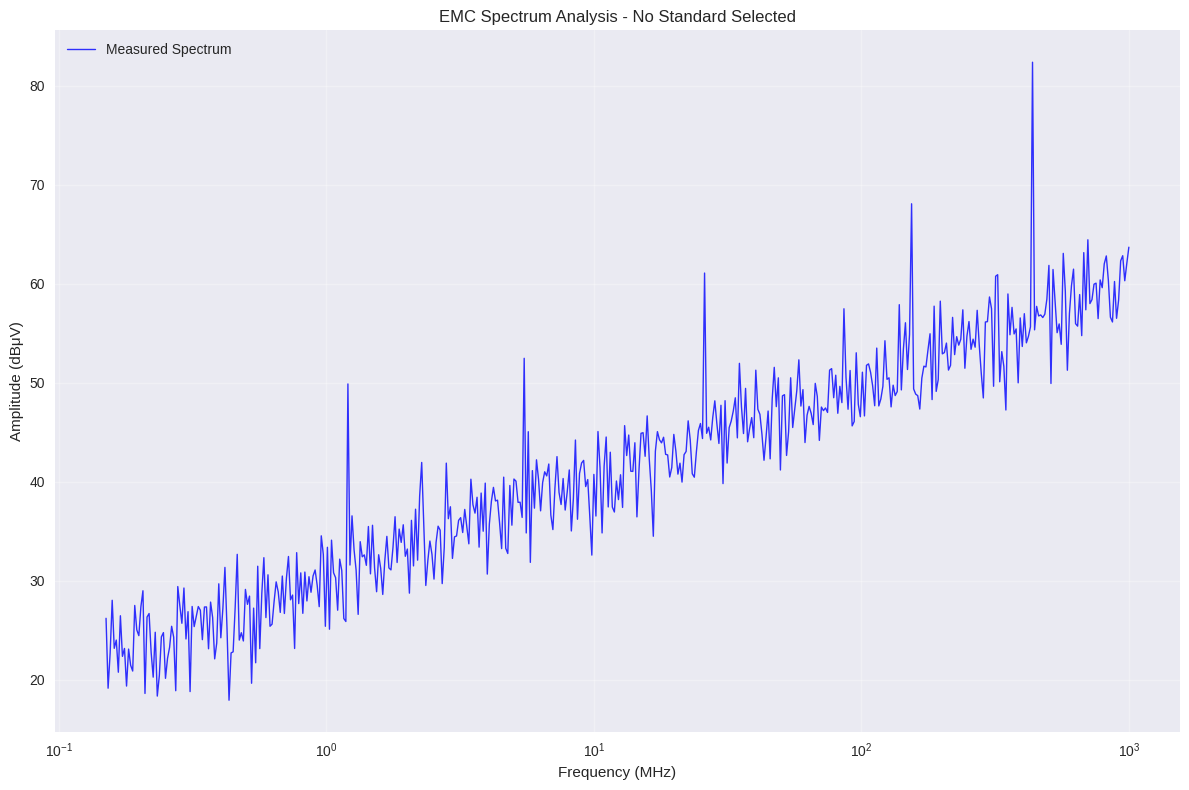


📋 Tabella riassuntiva:
      Parameter            Value   Unit
Frequency Range 0.150 - 1000.000    MHz
  Min Frequency            0.150    MHz
  Max Frequency         1000.000    MHz
    Data Points              500 points
  Min Amplitude             17.9   dBμV
  Max Amplitude             82.4   dBμV
 Mean Amplitude             41.2   dBμV


In [17]:
def plot_spectrum_with_masks(measurement_data, emc_standards, selected_standard=None, 
                            freq_range=None, interactive=True):
    """
    Visualizza spettro con maschere EMC (come nella web app)
    """
    if interactive:
        # Usa Plotly per interattività
        fig = go.Figure()
        
        # Plot spettro misurato
        fig.add_trace(go.Scatter(
            x=measurement_data['frequency'],
            y=measurement_data['amplitude'],
            mode='lines+markers',
            name='Measured Spectrum',
            line=dict(color='blue', width=1),
            marker=dict(size=3)
        ))
        
        # Plot maschere EMC se standard selezionato
        if selected_standard and selected_standard in emc_standards:
            std_data = emc_standards[selected_standard]
            colors = {'AVG': 'green', 'QP': 'orange', 'PK': 'red'}
            
            for limit_type, limit_data in std_data['limits'].items():
                if limit_data:
                    mask_df = generate_logarithmic_mask(limit_data, freq_range)
                    if not mask_df.empty:
                        fig.add_trace(go.Scatter(
                            x=mask_df['frequency'],
                            y=mask_df['amplitude'],
                            mode='lines',
                            name=f'{limit_type} Limit',
                            line=dict(color=colors.get(limit_type, 'gray'), width=2, dash='dash')
                        ))
        
        # Configurazione assi
        fig.update_layout(
            title=f"EMC Spectrum Analysis - {selected_standard if selected_standard else 'No Standard Selected'}",
            xaxis_title="Frequency (MHz)",
            yaxis_title="Amplitude (dBμV)",
            xaxis_type="log",
            xaxis=dict(showgrid=True, gridcolor='lightgray'),
            yaxis=dict(showgrid=True, gridcolor='lightgray'),
            height=600,
            hovermode='x unified'
        )
        
        if freq_range:
            fig.update_xaxes(range=[np.log10(freq_range[0]), np.log10(freq_range[1])])
        
        fig.show()
    
    else:
        # Usa Matplotlib per plot statico
        plt.figure(figsize=(12, 8))
        
        # Plot spettro
        plt.semilogx(measurement_data['frequency'], measurement_data['amplitude'], 
                    'b-', linewidth=1, label='Measured Spectrum', alpha=0.8)
        
        # Plot maschere
        if selected_standard and selected_standard in emc_standards:
            std_data = emc_standards[selected_standard]
            colors = {'AVG': 'green', 'QP': 'orange', 'PK': 'red'}
            
            for limit_type, limit_data in std_data['limits'].items():
                if limit_data:
                    mask_df = generate_logarithmic_mask(limit_data, freq_range)
                    if not mask_df.empty:
                        plt.semilogx(mask_df['frequency'], mask_df['amplitude'], 
                                   color=colors.get(limit_type, 'gray'), 
                                   linewidth=2, linestyle='--', 
                                   label=f'{limit_type} Limit')
        
        plt.xlabel('Frequency (MHz)')
        plt.ylabel('Amplitude (dBμV)')
        plt.title(f"EMC Spectrum Analysis - {selected_standard if selected_standard else 'No Standard Selected'}")
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        if freq_range:
            plt.xlim(freq_range)
        
        plt.tight_layout()
        plt.show()

def compare_multiple_standards(measurement_data, emc_standards, standard_list, freq_range=None):
    """
    Confronta spettro con multipli standard EMC
    """
    fig = go.Figure()
    
    # Plot spettro misurato
    fig.add_trace(go.Scatter(
        x=measurement_data['frequency'],
        y=measurement_data['amplitude'],
        mode='lines+markers',
        name='Measured Spectrum',
        line=dict(color='blue', width=2),
        marker=dict(size=3)
    ))
    
    # Colori per standard diversi
    standard_colors = ['green', 'orange', 'red', 'purple', 'brown', 'pink']
    
    for i, std_id in enumerate(standard_list):
        if std_id in emc_standards:
            std_data = emc_standards[std_id]
            color = standard_colors[i % len(standard_colors)]
            
            # Usa solo QP se disponibile, altrimenti AVG
            limit_type = 'QP' if 'QP' in std_data['limits'] else 'AVG'
            limit_data = std_data['limits'].get(limit_type)
            
            if limit_data:
                mask_df = generate_logarithmic_mask(limit_data, freq_range)
                if not mask_df.empty:
                    fig.add_trace(go.Scatter(
                        x=mask_df['frequency'],
                        y=mask_df['amplitude'],
                        mode='lines',
                        name=f'{std_data["name"]} ({limit_type})',
                        line=dict(color=color, width=2, dash='dash')
                    ))
    
    fig.update_layout(
        title="EMC Spectrum Analysis - Multiple Standards Comparison",
        xaxis_title="Frequency (MHz)",
        yaxis_title="Amplitude (dBμV)",
        xaxis_type="log",
        xaxis=dict(showgrid=True, gridcolor='lightgray'),
        yaxis=dict(showgrid=True, gridcolor='lightgray'),
        height=600,
        hovermode='x unified'
    )
    
    if freq_range:
        fig.update_xaxes(range=[np.log10(freq_range[0]), np.log10(freq_range[1])])
    
    fig.show()

def create_summary_table(measurement_data, emc_standards, selected_standard=None):
    """
    Crea tabella riassuntiva con statistiche
    """
    summary = {
        'Parameter': [],
        'Value': [],
        'Unit': []
    }
    
    # Statistiche spettro
    summary['Parameter'].extend(['Frequency Range', 'Min Frequency', 'Max Frequency', 
                                'Data Points', 'Min Amplitude', 'Max Amplitude', 'Mean Amplitude'])
    
    freq_min, freq_max = measurement_data['frequency'].min(), measurement_data['frequency'].max()
    amp_min, amp_max = measurement_data['amplitude'].min(), measurement_data['amplitude'].max()
    amp_mean = measurement_data['amplitude'].mean()
    
    summary['Value'].extend([f"{freq_min:.3f} - {freq_max:.3f}", f"{freq_min:.3f}", f"{freq_max:.3f}",
                            len(measurement_data), f"{amp_min:.1f}", f"{amp_max:.1f}", f"{amp_mean:.1f}"])
    
    summary['Unit'].extend(['MHz', 'MHz', 'MHz', 'points', 'dBμV', 'dBμV', 'dBμV'])
    
    # Info standard
    if selected_standard and selected_standard in emc_standards:
        std_data = emc_standards[selected_standard]
        summary['Parameter'].extend(['Standard', 'Available Limits'])
        summary['Value'].extend([std_data['name'], ', '.join(std_data['limits'].keys())])
        summary['Unit'].extend(['', ''])
    
    return pd.DataFrame(summary)

# Test visualizzazione
print("🎯 Funzioni di visualizzazione pronte!")
if 'sample_data' in locals():
    print("📊 Prova plot di esempio...")
    plot_spectrum_with_masks(sample_data, emc_standards, interactive=False)
    
    # Tabella riassuntiva
    summary_df = create_summary_table(sample_data, emc_standards)
    print("\n📋 Tabella riassuntiva:")
    print(summary_df.to_string(index=False))

## 4. Peak Detection and Analysis

In [19]:
import scipy

In [ ]:
def detect_peaks(measurement_data, height_threshold=None, prominence=5, distance=10):
    """
    Rileva picchi nello spettro con algoritmi avanzati
    """
    frequencies = measurement_data['frequency'].values
    amplitudes = measurement_data['amplitude'].values
    
    # Determina soglia automatica se non specificata
    if height_threshold is None:
        height_threshold = np.mean(amplitudes) + np.std(amplitudes)
    
    # Trova picchi usando scipy
    peaks, properties = scipy.signal.find_peaks(
        amplitudes, 
        height=height_threshold,
        prominence=prominence,
        distance=distance
    )
    
    # Crea DataFrame con informazioni sui picchi
    peaks_df = pd.DataFrame({
        'peak_index': peaks,
        'frequency': frequencies[peaks],
        'amplitude': amplitudes[peaks],
        'prominence': properties['prominences'],
        'width': properties.get('widths', [np.nan] * len(peaks))
    })
    
    # Ordina per ampiezza decrescente
    peaks_df = peaks_df.sort_values('amplitude', ascending=False).reset_index(drop=True)
    
    print(f"🔍 Rilevati {len(peaks_df)} picchi con soglia {height_threshold:.1f} dBμV")
    if len(peaks_df) > 0:
        print(f"   - Picco massimo: {peaks_df.iloc[0]['frequency']:.3f} MHz @ {peaks_df.iloc[0]['amplitude']:.1f} dBμV")
        print(f"   - Picco minimo: {peaks_df.iloc[-1]['frequency']:.3f} MHz @ {peaks_df.iloc[-1]['amplitude']:.1f} dBμV")
    
    return peaks_df

def analyze_peaks_vs_limits(peaks_df, emc_standards, selected_standard, limit_type='QP'):
    """
    Analizza picchi vs limiti EMC
    """
    if selected_standard not in emc_standards:
        print(f"❌ Standard {selected_standard} non trovato")
        return pd.DataFrame()
    
    std_data = emc_standards[selected_standard]
    limit_data = std_data['limits'].get(limit_type)
    
    if not limit_data:
        print(f"❌ Limite {limit_type} non disponibile per {selected_standard}")
        return pd.DataFrame()
    
    # Genera maschera interpolata
    mask_df = generate_logarithmic_mask(limit_data)
    
    if mask_df.empty:
        print("❌ Impossibile generare maschera")
        return pd.DataFrame()
    
    # Analizza ogni picco
    analysis_results = []
    
    for _, peak in peaks_df.iterrows():
        peak_freq = peak['frequency']
        peak_amp = peak['amplitude']
        
        # Trova limite alla frequenza del picco (interpolazione)
        limit_amp = np.interp(peak_freq, mask_df['frequency'], mask_df['amplitude'])
        
        # Calcola margine
        margin = limit_amp - peak_amp
        
        analysis_results.append({
            'frequency': peak_freq,
            'peak_amplitude': peak_amp,
            'limit_amplitude': limit_amp,
            'margin': margin,
            'compliance': 'PASS' if margin > 0 else 'FAIL',
            'prominence': peak['prominence']
        })
    
    results_df = pd.DataFrame(analysis_results)
    
    # Statistiche
    total_peaks = len(results_df)
    passing_peaks = len(results_df[results_df['compliance'] == 'PASS'])
    failing_peaks = len(results_df[results_df['compliance'] == 'FAIL'])
    
    print(f"\n📊 Analisi picchi vs {selected_standard} ({limit_type}):")
    print(f"   - Totale picchi: {total_peaks}")
    print(f"   - Picchi conformi: {passing_peaks} ({100*passing_peaks/total_peaks:.1f}%)")
    print(f"   - Picchi non conformi: {failing_peaks} ({100*failing_peaks/total_peaks:.1f}%)")
    
    if failing_peaks > 0:
        worst_violation = results_df[results_df['compliance'] == 'FAIL']['margin'].min()
        print(f"   - Violazione peggiore: {worst_violation:.1f} dB")
    
    return results_df

def plot_peaks_analysis(measurement_data, peaks_df, emc_standards, selected_standard, limit_type='QP'):
    """
    Visualizza analisi picchi con evidenziazione violazioni
    """
    fig = go.Figure()
    
    # Spettro base
    fig.add_trace(go.Scatter(
        x=measurement_data['frequency'],
        y=measurement_data['amplitude'],
        mode='lines',
        name='Measured Spectrum',
        line=dict(color='lightblue', width=1)
    ))
    
    # Maschera EMC
    if selected_standard in emc_standards:
        std_data = emc_standards[selected_standard]
        limit_data = std_data['limits'].get(limit_type)
        
        if limit_data:
            mask_df = generate_logarithmic_mask(limit_data)
            if not mask_df.empty:
                fig.add_trace(go.Scatter(
                    x=mask_df['frequency'],
                    y=mask_df['amplitude'],
                    mode='lines',
                    name=f'{limit_type} Limit',
                    line=dict(color='red', width=2, dash='dash')
                ))
    
    # Picchi - colore basato su conformità
    if not peaks_df.empty:
        # Analizza conformità
        compliance_df = analyze_peaks_vs_limits(peaks_df, emc_standards, selected_standard, limit_type)
        
        if not compliance_df.empty:
            # Picchi conformi
            passing_peaks = compliance_df[compliance_df['compliance'] == 'PASS']
            if not passing_peaks.empty:
                fig.add_trace(go.Scatter(
                    x=passing_peaks['frequency'],
                    y=passing_peaks['peak_amplitude'],
                    mode='markers',
                    name='Compliant Peaks',
                    marker=dict(color='green', size=8, symbol='triangle-up')
                ))
            
            # Picchi non conformi
            failing_peaks = compliance_df[compliance_df['compliance'] == 'FAIL']
            if not failing_peaks.empty:
                fig.add_trace(go.Scatter(
                    x=failing_peaks['frequency'],
                    y=failing_peaks['peak_amplitude'],
                    mode='markers',
                    name='Non-Compliant Peaks',
                    marker=dict(color='red', size=10, symbol='x')
                ))
    
    fig.update_layout(
        title=f"EMC Peak Analysis - {selected_standard} ({limit_type})",
        xaxis_title="Frequency (MHz)",
        yaxis_title="Amplitude (dBμV)",
        xaxis_type="log",
        height=600,
        hovermode='x unified'
    )
    
    fig.show()

def export_analysis_results(peaks_df, compliance_df, filename='emc_analysis_results.csv'):
    """
    Esporta risultati analisi in CSV
    """
    # Unisci dati picchi e conformità
    if not compliance_df.empty:
        merged_df = pd.merge(peaks_df, compliance_df, on='frequency', how='left')
        merged_df.to_csv(f'exports/{filename}', index=False)
        print(f"✅ Risultati esportati in exports/{filename}")
        return merged_df
    else:
        peaks_df.to_csv(f'exports/{filename}', index=False)
        print(f"✅ Picchi esportati in exports/{filename}")
        return peaks_df

# Test rilevamento picchi
print("🔍 Funzioni di rilevamento picchi pronte!")
if 'sample_data' in locals():
    print("🎯 Test rilevamento picchi...")
    detected_peaks = detect_peaks(sample_data, prominence=3, distance=5)
    
    if not detected_peaks.empty:
        print(f"\n📋 Top 5 picchi rilevati:")
        print(detected_peaks.head().to_string(index=False, float_format='%.3f'))
        
        # Test analisi vs standard (se disponibile)
        if emc_standards:
            first_standard = list(emc_standards.keys())[0]
            print(f"\n🔬 Test analisi vs {first_standard}...")
            compliance_results = analyze_peaks_vs_limits(detected_peaks, emc_standards, first_standard)

🔍 Funzioni di rilevamento picchi pronte!
🎯 Test rilevamento picchi...
🔍 Rilevati 19 picchi con soglia 52.7 dBμV
   - Picco massimo: 436.347 MHz @ 82.4 dBμV
   - Picco minimo: 95.676 MHz @ 53.0 dBμV

📋 Top 5 picchi rilevati:
 peak_index  frequency  amplitude  prominence  width
        452    436.347     82.366      32.457    NaN
        393    154.066     68.064      20.834    NaN
        479    702.647     64.427       8.304    NaN
        467    568.564     63.054      11.806    NaN
        488    823.579     62.795       6.332    NaN

🔬 Test analisi vs ECE_R10_Conducted_AC_lines...
❌ Limite QP non disponibile per ECE_R10_Conducted_AC_lines


## 5. Interactive Analysis Dashboard

Run the cells below to create an interactive dashboard for EMC spectrum analysis:

In [21]:
from ipywidgets import interact, widgets, Layout
from IPython.display import display, clear_output

def create_interactive_dashboard(measurement_data, emc_standards):
    """
    Crea dashboard interattivo per analisi EMC
    """
    # Widget per selezione standard
    standard_options = [('None', None)] + [(std_data['name'], std_id) 
                                          for std_id, std_data in emc_standards.items()]
    
    standard_widget = widgets.Dropdown(
        options=standard_options,
        value=None,
        description='EMC Standard:',
        style={'description_width': 'initial'},
        layout=Layout(width='300px')
    )
    
    # Widget per tipo limite
    limit_widget = widgets.Dropdown(
        options=['AVG', 'QP', 'PK'],
        value='QP',
        description='Limit Type:',
        style={'description_width': 'initial'},
        layout=Layout(width='150px')
    )
    
    # Widget per parametri rilevamento picchi
    prominence_widget = widgets.FloatSlider(
        value=5.0,
        min=1.0,
        max=20.0,
        step=0.5,
        description='Prominence:',
        style={'description_width': 'initial'},
        layout=Layout(width='300px')
    )
    
    distance_widget = widgets.IntSlider(
        value=10,
        min=1,
        max=50,
        description='Distance:',
        style={'description_width': 'initial'},
        layout=Layout(width='300px')
    )
    
    # Widget per range frequenza
    freq_min, freq_max = measurement_data['frequency'].min(), measurement_data['frequency'].max()
    
    freq_range_widget = widgets.FloatRangeSlider(
        value=[freq_min, freq_max],
        min=freq_min,
        max=freq_max,
        step=(freq_max - freq_min) / 100,
        description='Freq Range:',
        style={'description_width': 'initial'},
        layout=Layout(width='400px')
    )
    
    # Output area
    output = widgets.Output()
    
    def update_analysis(standard_id, limit_type, prominence, distance, freq_range):
        with output:
            clear_output(wait=True)
            
            # Filtra dati per range frequenza
            filtered_data = measurement_data[
                (measurement_data['frequency'] >= freq_range[0]) & 
                (measurement_data['frequency'] <= freq_range[1])
            ]
            
            print(f"📊 Analisi per range {freq_range[0]:.3f} - {freq_range[1]:.3f} MHz")
            print(f"   - Dati filtrati: {len(filtered_data)} punti")
            
            # Rileva picchi
            peaks_df = detect_peaks(filtered_data, prominence=prominence, distance=distance)
            
            if not peaks_df.empty:
                print(f"\n🔍 Rilevati {len(peaks_df)} picchi")
                
                # Analizza vs standard se selezionato
                if standard_id:
                    compliance_df = analyze_peaks_vs_limits(peaks_df, emc_standards, standard_id, limit_type)
                    
                    # Plot con analisi
                    plot_peaks_analysis(filtered_data, peaks_df, emc_standards, standard_id, limit_type)
                    
                    # Tabella risultati
                    if not compliance_df.empty:
                        print("\n📋 Risultati analisi conformità:")
                        print(compliance_df.to_string(index=False, float_format='%.2f'))
                else:
                    # Plot solo con picchi
                    plot_spectrum_with_masks(filtered_data, emc_standards, 
                                           selected_standard=standard_id, interactive=True)
                    
                    # Evidenzia picchi
                    fig = go.Figure()
                    fig.add_trace(go.Scatter(
                        x=filtered_data['frequency'],
                        y=filtered_data['amplitude'],
                        mode='lines',
                        name='Spectrum',
                        line=dict(color='blue', width=1)
                    ))
                    
                    fig.add_trace(go.Scatter(
                        x=peaks_df['frequency'],
                        y=peaks_df['amplitude'],
                        mode='markers',
                        name='Detected Peaks',
                        marker=dict(color='red', size=8, symbol='triangle-up')
                    ))
                    
                    fig.update_layout(
                        title="Peak Detection Results",
                        xaxis_title="Frequency (MHz)",
                        yaxis_title="Amplitude (dBμV)",
                        xaxis_type="log",
                        height=500
                    )
                    
                    fig.show()
                    
                    # Tabella picchi
                    print("\n📋 Picchi rilevati:")
                    print(peaks_df.to_string(index=False, float_format='%.3f'))
            
            else:
                print("❌ Nessun picco rilevato con i parametri attuali")
                plot_spectrum_with_masks(filtered_data, emc_standards, 
                                       selected_standard=standard_id, interactive=True)
    
    # Crea interfaccia interattiva
    interact(update_analysis,
             standard_id=standard_widget,
             limit_type=limit_widget,
             prominence=prominence_widget,
             distance=distance_widget,
             freq_range=freq_range_widget)
    
    display(output)

# Test widget interattivi
print("🎛️ Dashboard interattivo pronto!")
if 'sample_data' in locals() and emc_standards:
    print("🚀 Creazione dashboard...")
    create_interactive_dashboard(sample_data, emc_standards)
else:
    print("⚠️  Carica prima i dati di misura e gli standard EMC per usare il dashboard")

🎛️ Dashboard interattivo pronto!
🚀 Creazione dashboard...


interactive(children=(Dropdown(description='EMC Standard:', layout=Layout(width='300px'), options=(('None', No…

Output()

## 6. Example Usage and Next Steps

### Quick Start Guide:

1. **Load your data**: Use `parse_measurement_data('your_file.csv')` to load measurement data
2. **Load EMC standards**: Use `load_emc_standards()` to load standard definitions
3. **Visualize**: Use `plot_spectrum_with_masks()` to plot spectrum with EMC limits
4. **Detect peaks**: Use `detect_peaks()` to find spectrum peaks
5. **Analyze compliance**: Use `analyze_peaks_vs_limits()` to check against EMC standards
6. **Interactive analysis**: Use the dashboard above for dynamic exploration

### Advanced Features:

- **Multiple standards comparison**: Use `compare_multiple_standards()` 
- **Export results**: Use `export_analysis_results()` to save analysis to CSV
- **Custom frequency ranges**: All functions support frequency range filtering
- **Adjustable peak detection**: Tune prominence and distance parameters

### Integration with Web App:

This notebook uses the same EMC standards JSON file and logarithmic interpolation algorithms as the web application, ensuring consistency between rapid prototyping here and the production interface.

🚀 EMC Spectrum Analysis Notebook - Complete Setup

1️⃣ Loading EMC standards...
✅ Caricati 6 standard EMC:
   - ECE R-10 2012 AC line (avg, qp)
   - ECE R-10 2012 DC line (avg, qp)
   - EN 55032 Class A (avg, qp, pk)
   - EN 55032 Class B (avg, qp, pk)
   - CISPR 32 Class A (avg, qp, pk)
   - CISPR 32 Class B (avg, qp, pk)

2️⃣ Loading measurement data...
   - Data points: 500
   - Frequency range: 0.150 - 1000.000 MHz

3️⃣ Creating visualization...
   - Using standard: ECE R-10 2012 AC line


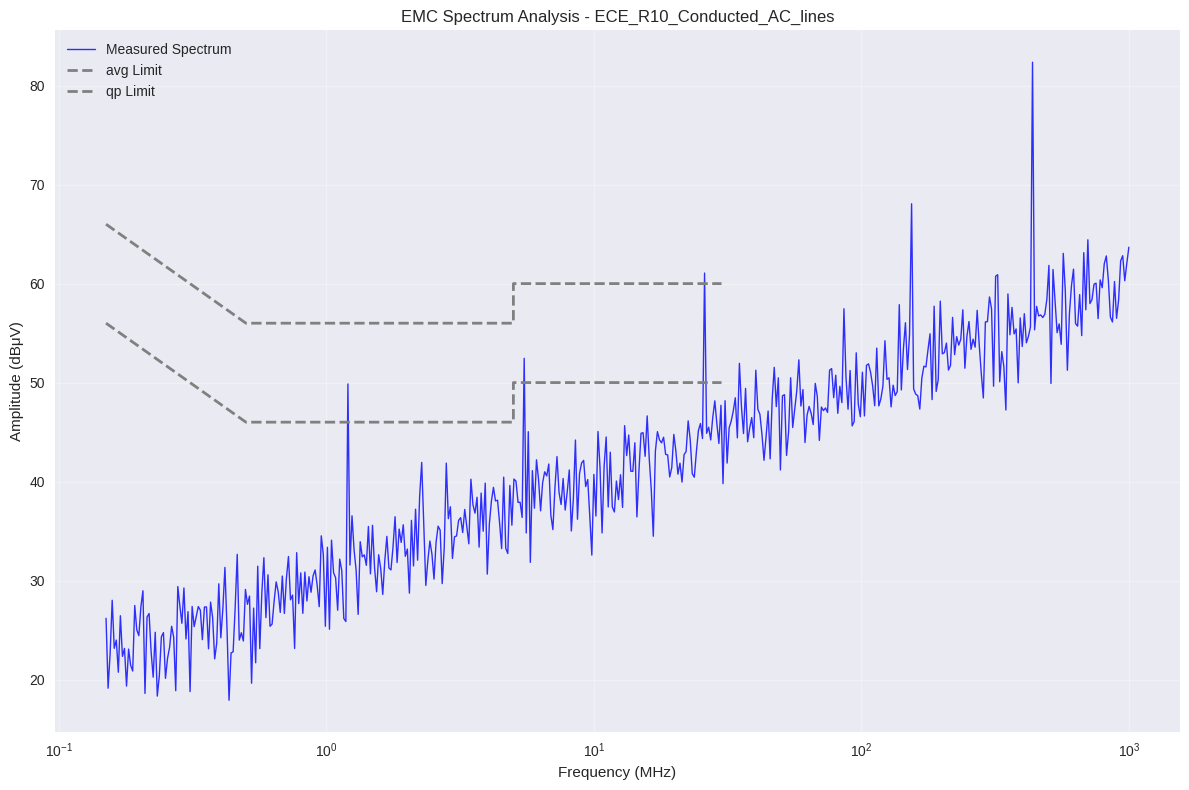


4️⃣ Peak detection and compliance analysis...
🔍 Rilevati 19 picchi con soglia 52.7 dBμV
   - Picco massimo: 436.347 MHz @ 82.4 dBμV
   - Picco minimo: 95.676 MHz @ 53.0 dBμV
❌ Limite QP non disponibile per ECE_R10_Conducted_AC_lines

📊 Analysis Summary:
   - Total peaks detected: 19

📋 Measurement Summary:
       Parameter                 Value   Unit
 Frequency Range      0.150 - 1000.000    MHz
   Min Frequency                 0.150    MHz
   Max Frequency              1000.000    MHz
     Data Points                   500 points
   Min Amplitude                  17.9   dBμV
   Max Amplitude                  82.4   dBμV
  Mean Amplitude                  41.2   dBμV
        Standard ECE R-10 2012 AC line       
Available Limits               avg, qp       

✅ Setup complete! You can now:
   - Run the interactive dashboard above
   - Load your own measurement data
   - Experiment with different EMC standards
   - Adjust peak detection parameters
   - Export results to CSV

🎯 Ready for

In [22]:
# Example workflow demonstration
print("🚀 EMC Spectrum Analysis Notebook - Complete Setup")
print("="*50)

# 1. Load EMC standards
print("\n1️⃣ Loading EMC standards...")
emc_standards = load_emc_standards()

# 2. Create or load measurement data
print("\n2️⃣ Loading measurement data...")
if 'sample_data' not in locals():
    # Generate sample data if not already created
    frequencies = np.logspace(np.log10(0.15), np.log10(1000), 500)
    base_signal = 30 + 10 * np.log10(frequencies)
    noise = np.random.normal(0, 3, len(frequencies))
    
    # Add some interesting peaks
    peaks_freq = [1.2, 5.5, 25.8, 155.0, 433.0]
    peaks_amp = [15, 20, 12, 18, 25]
    
    amplitudes = base_signal + noise
    for pf, pa in zip(peaks_freq, peaks_amp):
        idx = np.argmin(np.abs(frequencies - pf))
        amplitudes[idx] += pa
    
    sample_data = pd.DataFrame({
        'frequency': frequencies,
        'amplitude': amplitudes
    })

print(f"   - Data points: {len(sample_data)}")
print(f"   - Frequency range: {sample_data['frequency'].min():.3f} - {sample_data['frequency'].max():.3f} MHz")

# 3. Quick visualization
print("\n3️⃣ Creating visualization...")
if emc_standards:
    first_standard = list(emc_standards.keys())[0]
    print(f"   - Using standard: {emc_standards[first_standard]['name']}")
    
    # Plot with EMC limits
    plot_spectrum_with_masks(sample_data, emc_standards, first_standard, interactive=False)
    
    # 4. Peak detection and analysis
    print("\n4️⃣ Peak detection and compliance analysis...")
    peaks_df = detect_peaks(sample_data, prominence=3, distance=5)
    
    if not peaks_df.empty:
        compliance_df = analyze_peaks_vs_limits(peaks_df, emc_standards, first_standard, 'QP')
        
        print(f"\n📊 Analysis Summary:")
        print(f"   - Total peaks detected: {len(peaks_df)}")
        
        if not compliance_df.empty:
            passing = len(compliance_df[compliance_df['compliance'] == 'PASS'])
            failing = len(compliance_df[compliance_df['compliance'] == 'FAIL'])
            print(f"   - Compliant peaks: {passing}")
            print(f"   - Non-compliant peaks: {failing}")
            
            if failing > 0:
                worst_margin = compliance_df[compliance_df['compliance'] == 'FAIL']['margin'].min()
                print(f"   - Worst violation: {worst_margin:.1f} dB")
        
        # Create summary table
        summary_table = create_summary_table(sample_data, emc_standards, first_standard)
        print(f"\n📋 Measurement Summary:")
        print(summary_table.to_string(index=False))

print("\n✅ Setup complete! You can now:")
print("   - Run the interactive dashboard above")
print("   - Load your own measurement data")
print("   - Experiment with different EMC standards")
print("   - Adjust peak detection parameters")
print("   - Export results to CSV")

print(f"\n🎯 Ready for EMC analysis! Available standards:")
for std_id, std_data in emc_standards.items():
    limit_types = list(std_data['limits'].keys())
    print(f"   - {std_data['name']} ({', '.join(limit_types)})")